In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tqdm.notebook import tqdm

In [2]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [3]:
# !kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

In [4]:
# import zipfile
# zip_ref = zipfile.ZipFile('/content/face-expression-recognition-dataset.zip', 'r')
# zip_ref.extractall('/content')
# zip_ref.close()

In [5]:
TRAIN_DIR = '/content/images/train'
TEST_DIR = '/content/images/validation'

In [6]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir, label)):
            image_paths.append(os.path.join(dir,label, imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths,labels

In [7]:
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

disgust completed
neutral completed
surprise completed
fear completed
happy completed
sad completed
angry completed


In [8]:
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)

disgust completed
neutral completed
surprise completed
fear completed
happy completed
sad completed
angry completed


In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode = "grayscale")
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48,48,1)
    return features

In [10]:
train_features = extract_features(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

In [11]:
test_features = extract_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [12]:
x_train = train_features/255.0
x_test = test_features/225.0

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [14]:
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [15]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model = Sequential()

model.add(Conv2D(6, kernel_size=(5, 5), strides=(1,1), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(Dropout(0.25))

model.add(Conv2D(16, kernel_size=(5, 5),strides=(2,2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(32, kernel_size=(5, 5), strides=(2,2), activation='relu', padding='same'))

model.add(Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(320, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(80, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 6)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 42, 42, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 16)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 16)        0

In [17]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')

In [18]:
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [19]:
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test), callbacks= early_stopping)

Epoch 1/100
226/226 [==============================] - 11s 12ms/step - loss: 1.7813 - accuracy: 0.2716 - val_loss: 1.6363 - val_accuracy: 0.3517
Epoch 2/100
226/226 [==============================] - 2s 8ms/step - loss: 1.6268 - accuracy: 0.3630 - val_loss: 1.5194 - val_accuracy: 0.4142
Epoch 3/100
226/226 [==============================] - 2s 8ms/step - loss: 1.5485 - accuracy: 0.4002 - val_loss: 1.4347 - val_accuracy: 0.4466
Epoch 4/100
226/226 [==============================] - 2s 8ms/step - loss: 1.4910 - accuracy: 0.4241 - val_loss: 1.4328 - val_accuracy: 0.4452
Epoch 5/100
226/226 [==============================] - 2s 9ms/step - loss: 1.4456 - accuracy: 0.4432 - val_loss: 1.3657 - val_accuracy: 0.4827
Epoch 6/100
226/226 [==============================] - 2s 8ms/step - loss: 1.4090 - accuracy: 0.4598 - val_loss: 1.3263 - val_accuracy: 0.4870
Epoch 7/100
226/226 [==============================] - 2s 8ms/step - loss: 1.3863 - accuracy: 0.4683 - val_loss: 1.2924 - val_accuracy: 0.50

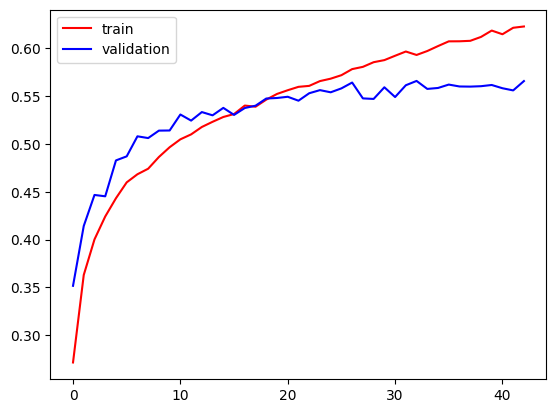

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'],color = 'blue', label = 'validation')
plt.legend()
plt.show()

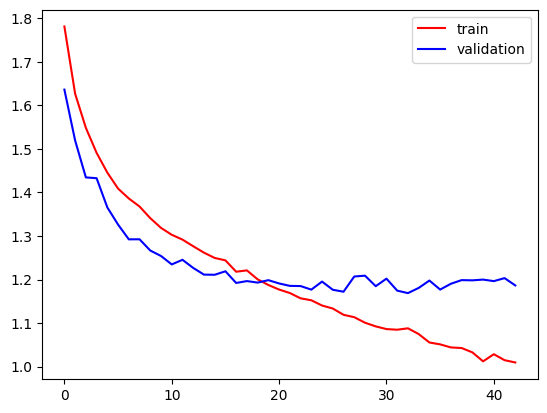

In [21]:
plt.plot(history.history['loss'],color = 'red', label = 'train')
plt.plot(history.history['val_loss'],color = 'blue', label = 'validation')
plt.legend()
plt.show()

In [22]:
model_json = model.to_json()
with open("emotiondetector.json",'w') as json_file:
    json_file.write(model_json)
model.save("emotiondetector.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
from keras.models import model_from_json

In [24]:
json_file = open("/content/emotiondetector.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("/content/emotiondetector.h5")

In [25]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [26]:
def ef(image):
    img = load_img(image,grayscale =  True )
    feature = np.array(img)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0

In [27]:
image = 'images/train/sad/42.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)

original image is of sad


/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 214ms/step
model prediction is  sad


original image is of sad
1/1 [==============================] - 0s 60ms/step
model prediction is  sad


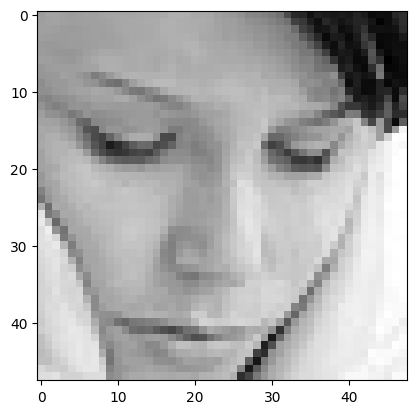

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
image = 'images/train/sad/42.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of fear
1/1 [==============================] - 0s 29ms/step
model prediction is  fear


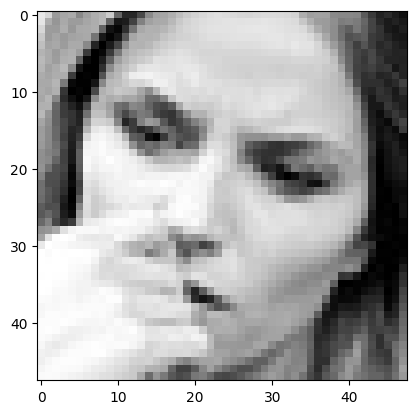

In [29]:
image = 'images/train/fear/2.jpg'
print("original image is of fear")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of happy
1/1 [==============================] - 0s 17ms/step
model prediction is  happy


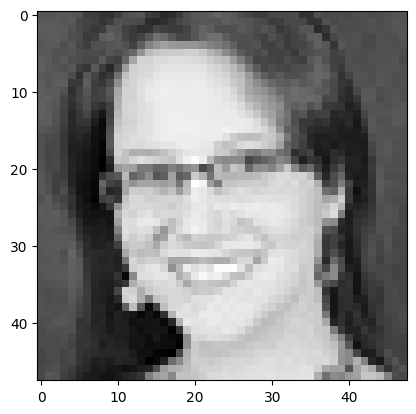

In [30]:
image = 'images/train/happy/7.jpg'
print("original image is of happy")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of happy
1/1 [==============================] - 0s 26ms/step
model prediction is  happy


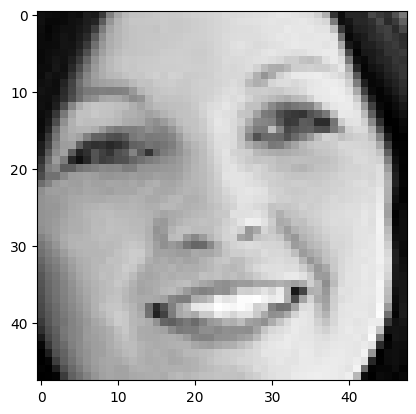

In [31]:
image = 'images/validation/happy/196.jpg'
print("original image is of happy")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')